# Light GBM Restaurant Forecasting Analysis - JS

In [159]:
import time
import numpy as np
import pandas as pd
from dateutil.parser import parse
from datetime import date, timedelta
from sklearn.preprocessing import LabelEncoder
import datetime
import lightgbm as lgb
import pickle
import joblib

import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn import metrics

In [41]:
data_path = '/Users/jenniferwu/Desktop/MSBA/Spring 2020/Predictive/fp_dat/'

air_reserve = pd.read_csv(data_path + 'air_reserve.csv').rename(columns={'air_store_id':'store_id'})
hpg_reserve = pd.read_csv(data_path + 'hpg_reserve.csv').rename(columns={'hpg_store_id':'store_id'})
air_store = pd.read_csv(data_path + 'air_store_info.csv').rename(columns={'air_store_id':'store_id'})
hpg_store = pd.read_csv(data_path + 'hpg_store_info.csv').rename(columns={'hpg_store_id':'store_id'})
air_visit = pd.read_csv(data_path + 'air_visit_data.csv').rename(columns={'air_store_id':'store_id'})
store_id_map = pd.read_csv(data_path + 'store_id_relation.csv').set_index('hpg_store_id',drop=False)
date_info = pd.read_csv(data_path + 'date_info.csv').rename(columns={'calendar_date': 'visit_date'}).drop('day_of_week',axis=1)
submission = pd.read_csv(data_path + 'sample_submission.csv')

In [42]:
print("===air_reserve===")
print(air_reserve.info(),"\n")
print("===hpg_reserve===")
print(hpg_reserve.info(),"\n")
print("===air_store===")
print(air_store.info(),"\n")
print("===hpg_store===")
print(hpg_store.info(),"\n")
print("===air_visit===")
print(air_visit.info(),"\n")
print("===store_id_map===")
print(store_id_map.info(),"\n")
print("===date_info===")
print(date_info.info(),"\n")

===air_reserve===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92378 entries, 0 to 92377
Data columns (total 4 columns):
store_id            92378 non-null object
visit_datetime      92378 non-null object
reserve_datetime    92378 non-null object
reserve_visitors    92378 non-null int64
dtypes: int64(1), object(3)
memory usage: 2.8+ MB
None 

===hpg_reserve===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000320 entries, 0 to 2000319
Data columns (total 4 columns):
store_id            object
visit_datetime      object
reserve_datetime    object
reserve_visitors    int64
dtypes: int64(1), object(3)
memory usage: 61.0+ MB
None 

===air_store===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 829 entries, 0 to 828
Data columns (total 5 columns):
store_id          829 non-null object
air_genre_name    829 non-null object
air_area_name     829 non-null object
latitude          829 non-null float64
longitude         829 non-null float64
dtypes: float64(2), object(3)
memory usage:

In [50]:
import warnings
warnings.simplefilter('ignore')

##cleaning the submission dataset - adding store id to join data later
submission['visit_date'] = submission['id'].str[-10:]
submission['store_id'] = submission['id'].str[:-11]

##adding DAY OF WEEK to reservation data
air_reserve['visit_date'] = air_reserve['visit_datetime'].str[:10]
air_reserve['reserve_date'] = air_reserve['reserve_datetime'].str[:10]
air_reserve['dow'] = pd.to_datetime(air_reserve['visit_date']).dt.dayofweek

hpg_reserve['visit_date'] = hpg_reserve['visit_datetime'].str[:10]
hpg_reserve['reserve_date'] = hpg_reserve['reserve_datetime'].str[:10]
hpg_reserve['dow'] = pd.to_datetime(hpg_reserve['visit_date']).dt.dayofweek

#create LAG VARIABLE (for forecasting period) = time between RESERVATION DATE to VISIT DATE 


#create "id" col as join key
air_visit['id'] = air_visit['store_id'] + '_' + air_visit['visit_date']
hpg_reserve['store_id'] = hpg_reserve['store_id'].map(store_id_map['air_store_id']).fillna(hpg_reserve['store_id'])
hpg_store['store_id'] = hpg_store['store_id'].map(store_id_map['air_store_id']).fillna(hpg_store['store_id'])
hpg_store.rename(columns={'hpg_genre_name':'air_genre_name','hpg_area_name':'air_area_name'},inplace=True)


data = pd.concat([air_visit, submission]).copy()
data['dow'] = pd.to_datetime(data['visit_date']).dt.dayofweek

#adding holiday flag
date_info['holiday_flg2'] = pd.to_datetime(date_info['visit_date']).dt.dayofweek
date_info['holiday_flg2'] = ((date_info['holiday_flg2']>4) | (date_info['holiday_flg']==1)).astype(int)

#create interaction terms between holiday flag x weekday


air_store['air_area_name0'] = air_store['air_area_name'].apply(lambda x: x.split(' ')[0])
lbl = LabelEncoder()
air_store['air_genre_name'] = lbl.fit_transform(air_store['air_genre_name'])
air_store['air_area_name0'] = lbl.fit_transform(air_store['air_area_name0'])

data['visitors'] = np.log1p(data['visitors'])
data = data.merge(air_store,on='store_id',how='left')
data = data.merge(date_info[['visit_date','holiday_flg','holiday_flg2']], on=['visit_date'],how='left')

In [51]:
data.head()

,id,store_id,visit_date,visitors,dow,air_genre_name,air_area_name,latitude,longitude,air_area_name0,holiday_flg,holiday_flg2
0,air_ba937bf13d40fb24_2016-01-13,air_ba937bf13d40fb24,2016-01-13,3.258097,2,4,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,7,0,0
1,air_ba937bf13d40fb24_2016-01-14,air_ba937bf13d40fb24,2016-01-14,3.496508,3,4,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,7,0,0
2,air_ba937bf13d40fb24_2016-01-15,air_ba937bf13d40fb24,2016-01-15,3.401197,4,4,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,7,0,0
3,air_ba937bf13d40fb24_2016-01-16,air_ba937bf13d40fb24,2016-01-16,3.135494,5,4,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,7,0,1
4,air_ba937bf13d40fb24_2016-01-18,air_ba937bf13d40fb24,2016-01-18,1.945910,0,4,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,7,0,0


## Function to Create Features

In [56]:
def concat(L):
    result = None
    for l in L:
        if result is None:
            result = l
        else:
            try:
                result[l.columns.tolist()] = l
            except:
                print(l.head())
    return result

def left_merge(data1,data2,on):
    if type(on) != list:
        on = [on]
    if (set(on) & set(data2.columns)) != set(on):
        data2_temp = data2.reset_index()
    else:
        data2_temp = data2.copy()
    columns = [f for f in data2.columns if f not in on]
    result = data1.merge(data2_temp,on=on,how='left')
    result = result[columns]
    return result


def diff_of_days(day1, day2):
    days = (parse(day1[:10]) - parse(day2[:10])).days
    return days

def date_add_days(start_date, days):
    end_date = parse(start_date[:10]) + timedelta(days=days)
    end_date = end_date.strftime('%Y-%m-%d')
    return end_date


def get_label(end_date,n_day):
    label_end_date = date_add_days(end_date, n_day)
    label = data[(data['visit_date'] < label_end_date) & (data['visit_date'] >= end_date)].copy()
    label['end_date'] = end_date
    label['diff_of_day'] = label['visit_date'].apply(lambda x: diff_of_days(x,end_date))
    label['month'] = label['visit_date'].str[5:7].astype(int)
    label['year'] = label['visit_date'].str[:4].astype(int)
    for i in [3,2,1,-1]:
        date_info_temp = date_info.copy()
        date_info_temp['visit_date'] = date_info_temp['visit_date'].apply(lambda x: date_add_days(x,i))
        date_info_temp.rename(columns={'holiday_flg':'ahead_holiday_{}'.format(i),'holiday_flg2':'ahead_holiday2_{}'.format(i)},inplace=True)
        label = label.merge(date_info_temp, on=['visit_date'],how='left')
    label = label.reset_index(drop=True)
    return label


def get_store_visitor_feat(label, key, n_day):
    start_date = date_add_days(key[0],-n_day)
    data_temp = data[(data.visit_date < key[0]) & (data.visit_date > start_date)].copy()
    result = data_temp.groupby(['store_id'], as_index=False)['visitors'].agg({'store_min{}'.format(n_day): 'min',
                                                                             'store_mean{}'.format(n_day): 'mean',
                                                                             'store_median{}'.format(n_day): 'median',
                                                                             'store_max{}'.format(n_day): 'max',
                                                                             'store_count{}'.format(n_day): 'count',
                                                                             'store_std{}'.format(n_day): 'std',
                                                                             'store_skew{}'.format(n_day): 'skew'})
    result = left_merge(label, result, on=['store_id']).fillna(0)
    return result


def get_store_exp_visitor_feat(label, key, n_day):
    start_date = date_add_days(key[0], -n_day)
    data_temp = data[(data.visit_date < key[0]) & (data.visit_date > start_date)].copy()
    data_temp['visit_date'] = data_temp['visit_date'].apply(lambda x: diff_of_days(key[0],x))
    data_temp['weight'] = data_temp['visit_date'].apply(lambda x: 0.985**x)
    data_temp['visitors'] = data_temp['visitors'] * data_temp['weight']
    result1 = data_temp.groupby(['store_id'], as_index=False)['visitors'].agg({'store_exp_mean{}'.format(n_day): 'sum'})
    result2 = data_temp.groupby(['store_id'], as_index=False)['weight'].agg({'store_exp_weight_sum{}'.format(n_day): 'sum'})
    result = result1.merge(result2, on=['store_id'], how='left')
    result['store_exp_mean{}'.format(n_day)] = result['store_exp_mean{}'.format(n_day)]/result['store_exp_weight_sum{}'.format(n_day)]
    result = left_merge(label, result, on=['store_id']).fillna(0)
    return result



def get_store_week_feat(label, key, n_day):
    start_date = date_add_days(key[0], -n_day)
    data_temp = data[(data.visit_date < key[0]) & (data.visit_date > start_date)].copy()
    result = data_temp.groupby(['store_id', 'dow'], as_index=False)['visitors'].agg({'store_dow_min{}'.format(n_day): 'min',
                                                                                     'store_dow_mean{}'.format(n_day): 'mean',
                                                                                     'store_dow_median{}'.format(n_day): 'median',
                                                                                     'store_dow_max{}'.format(n_day): 'max',
                                                                                     'store_dow_count{}'.format(n_day): 'count',
                                                                                     'store_dow_std{}'.format(n_day): 'std',
                                                                                     'store_dow_skew{}'.format(n_day): 'skew'})
    result = left_merge(label, result, on=['store_id', 'dow']).fillna(0)
    return result


def get_store_week_diff_feat(label, key, n_day):
    start_date = date_add_days(key[0], -n_day)
    data_temp = data[(data.visit_date < key[0]) & (data.visit_date > start_date)].copy()
    result = data_temp.set_index(['store_id','visit_date'])['visitors'].unstack()
    result = result.diff(axis=1).iloc[:,1:]
    c = result.columns
    result['store_diff_mean'] = np.abs(result[c]).mean(axis=1)
    result['store_diff_std'] = result[c].std(axis=1)
    result['store_diff_max'] = result[c].max(axis=1)
    result['store_diff_min'] = result[c].min(axis=1)
    result = left_merge(label, result[['store_diff_mean', 'store_diff_std', 'store_diff_max', 'store_diff_min']],on=['store_id']).fillna(0)
    return result

def get_store_all_week_feat(label, key, n_day):
    start_date = date_add_days(key[0], -n_day)
    data_temp = data[(data.visit_date < key[0]) & (data.visit_date > start_date)].copy()
    result_temp = data_temp.groupby(['store_id', 'dow'],as_index=False)['visitors'].agg({'store_dow_mean{}'.format(n_day): 'mean',
                                                                     'store_dow_median{}'.format(n_day): 'median',
                                                                     'store_dow_sum{}'.format(n_day): 'max',
                                                                     'store_dow_count{}'.format(n_day): 'count'})
    result = pd.DataFrame()
    for i in range(7):
        result_sub = result_temp[result_temp['dow']==i].copy()
        result_sub = result_sub.set_index('store_id')
        result_sub = result_sub.add_prefix(str(i))
        result_sub = left_merge(label, result_sub, on=['store_id']).fillna(0)
        result = pd.concat([result,result_sub],axis=1)
    return result


def get_store_week_exp_feat(label, key, n_day):
    start_date = date_add_days(key[0], -n_day)
    data_temp = data[(data.visit_date < key[0]) & (data.visit_date > start_date)].copy()
    data_temp['visit_date'] = data_temp['visit_date'].apply(lambda x: diff_of_days(key[0],x))
    data_temp['visitors2'] = data_temp['visitors']
    result = None
    for i in [0.9,0.95,0.97,0.98,0.985,0.99,0.999,0.9999]:
        data_temp['weight'] = data_temp['visit_date'].apply(lambda x: i**x)
        data_temp['visitors1'] = data_temp['visitors'] * data_temp['weight']
        data_temp['visitors2'] = data_temp['visitors2'] * data_temp['weight']
        result1 = data_temp.groupby(['store_id', 'dow'], as_index=False)['visitors1'].agg({'store_dow_exp_mean{}_{}'.format(n_day,i): 'sum'})
        result3 = data_temp.groupby(['store_id', 'dow'], as_index=False)['visitors2'].agg({'store_dow_exp_mean2{}_{}'.format(n_day, i): 'sum'})
        result2 = data_temp.groupby(['store_id', 'dow'], as_index=False)['weight'].agg({'store_dow_exp_weight_sum{}_{}'.format(n_day,i): 'sum'})
        result_temp = result1.merge(result2, on=['store_id', 'dow'], how='left')
        result_temp = result_temp.merge(result3, on=['store_id', 'dow'], how='left')
        result_temp['store_dow_exp_mean{}_{}'.format(n_day,i)] = result_temp['store_dow_exp_mean{}_{}'.format(n_day,i)]/result_temp['store_dow_exp_weight_sum{}_{}'.format(n_day,i)]
        result_temp['store_dow_exp_mean2{}_{}'.format(n_day, i)] = result_temp[ 'store_dow_exp_mean2{}_{}'.format(n_day, i)]/result_temp['store_dow_exp_weight_sum{}_{}'.format(n_day, i)]
        if result is None:
            result = result_temp
        else:
            result = result.merge(result_temp,on=['store_id','dow'],how='left')
    result = left_merge(label, result, on=['store_id', 'dow']).fillna(0)
    return result


def get_store_holiday_feat(label, key, n_day):
    start_date = date_add_days(key[0], -n_day)
    data_temp = data[(data.visit_date < key[0]) & (data.visit_date > start_date)].copy()
    result1 = data_temp.groupby(['store_id', 'holiday_flg'], as_index=False)['visitors'].agg(
        {'store_holiday_min{}'.format(n_day): 'min',
         'store_holiday_mean{}'.format(n_day): 'mean',
         'store_holiday_median{}'.format(n_day): 'median',
         'store_holiday_max{}'.format(n_day): 'max',
         'store_holiday_count{}'.format(n_day): 'count',
         'store_holiday_std{}'.format(n_day): 'std',
         'store_holiday_skew{}'.format(n_day): 'skew'})
    result1 = left_merge(label, result1, on=['store_id', 'holiday_flg']).fillna(0)
    result2 = data_temp.groupby(['store_id', 'holiday_flg2'], as_index=False)['visitors'].agg(
        {'store_holiday2_min{}'.format(n_day): 'min',
         'store_holiday2_mean{}'.format(n_day): 'mean',
         'store_holiday2_median{}'.format(n_day): 'median',
         'store_holiday2_max{}'.format(n_day): 'max',
         'store_holiday2_count{}'.format(n_day): 'count',
         'store_holiday2_std{}'.format(n_day): 'std',
         'store_holiday2_skew{}'.format(n_day): 'skew'})
    result2 = left_merge(label, result2, on=['store_id', 'holiday_flg2']).fillna(0)
    result = pd.concat([result1, result2], axis=1)
    return result


def get_genre_visitor_feat(label, key, n_day):
    start_date = date_add_days(key[0],-n_day)
    data_temp = data[(data.visit_date < key[0]) & (data.visit_date > start_date)].copy()
    result = data_temp.groupby(['air_genre_name'], as_index=False)['visitors'].agg({'genre_min{}'.format(n_day): 'min',
                                                                             'genre_mean{}'.format(n_day): 'mean',
                                                                             'genre_median{}'.format(n_day): 'median',
                                                                             'genre_max{}'.format(n_day): 'max',
                                                                             'genre_count{}'.format(n_day): 'count',
                                                                             'genre_std{}'.format(n_day): 'std',
                                                                             'genre_skew{}'.format(n_day): 'skew'})
    result = left_merge(label, result, on=['air_genre_name']).fillna(0)
    return result


def get_genre_exp_visitor_feat(label, key, n_day):
    start_date = date_add_days(key[0], -n_day)
    data_temp = data[(data.visit_date < key[0]) & (data.visit_date > start_date)].copy()
    data_temp['visit_date'] = data_temp['visit_date'].apply(lambda x: diff_of_days(key[0],x))
    data_temp['weight'] = data_temp['visit_date'].apply(lambda x: 0.985**x)
    data_temp['visitors'] = data_temp['visitors'] * data_temp['weight']
    result1 = data_temp.groupby(['air_genre_name'], as_index=False)['visitors'].agg({'genre_exp_mean{}'.format(n_day): 'sum'})
    result2 = data_temp.groupby(['air_genre_name'], as_index=False)['weight'].agg({'genre_exp_weight_sum{}'.format(n_day): 'sum'})
    result = result1.merge(result2, on=['air_genre_name'], how='left')
    result['genre_exp_mean{}'.format(n_day)] = result['genre_exp_mean{}'.format(n_day)]/result['genre_exp_weight_sum{}'.format(n_day)]
    result = left_merge(label, result, on=['air_genre_name']).fillna(0)
    return result


def get_genre_week_feat(label, key, n_day):
    start_date = date_add_days(key[0], -n_day)
    data_temp = data[(data.visit_date < key[0]) & (data.visit_date > start_date)].copy()
    result = data_temp.groupby(['air_genre_name', 'dow'], as_index=False)['visitors'].agg({'genre_dow_min{}'.format(n_day): 'min',
                                                                                         'genre_dow_mean{}'.format(n_day): 'mean',
                                                                                         'genre_dow_median{}'.format(n_day): 'median',
                                                                                         'genre_dow_max{}'.format(n_day): 'max',
                                                                                         'genre_dow_count{}'.format(n_day): 'count',
                                                                                         'genre_dow_std{}'.format(n_day): 'std',
                                                                                         'genre_dow_skew{}'.format(n_day): 'skew'})
    result = left_merge(label, result, on=['air_genre_name', 'dow']).fillna(0)
    return result


def get_genre_week_exp_feat(label, key, n_day):
    start_date = date_add_days(key[0], -n_day)
    data_temp = data[(data.visit_date < key[0]) & (data.visit_date > start_date)].copy()
    data_temp['visit_date'] = data_temp['visit_date'].apply(lambda x: diff_of_days(key[0],x))
    data_temp['weight'] = data_temp['visit_date'].apply(lambda x: 0.985**x)
    data_temp['visitors'] = data_temp['visitors'] * data_temp['weight']
    result1 = data_temp.groupby(['air_genre_name', 'dow'], as_index=False)['visitors'].agg({'genre_dow_exp_mean{}'.format(n_day): 'sum'})
    result2 = data_temp.groupby(['air_genre_name', 'dow'], as_index=False)['weight'].agg({'genre_dow_exp_weight_sum{}'.format(n_day): 'sum'})
    result = result1.merge(result2, on=['air_genre_name', 'dow'], how='left')
    result['genre_dow_exp_mean{}'.format(n_day)] = result['genre_dow_exp_mean{}'.format(n_day)]/result['genre_dow_exp_weight_sum{}'.format(n_day)]
    result = left_merge(label, result, on=['air_genre_name', 'dow']).fillna(0)
    return result



def get_first_last_time(label, key, n_day):
    start_date = date_add_days(key[0], -n_day)
    data_temp = data[(data.visit_date < key[0]) & (data.visit_date > start_date)].copy()
    data_temp = data_temp.sort_values('visit_date')
    result = data_temp.groupby('store_id')['visit_date'].agg({'first_time':lambda x: diff_of_days(key[0],np.min(x)),
                                                              'last_time':lambda x: diff_of_days(key[0],np.max(x)),})
    result = left_merge(label, result, on=['store_id']).fillna(0)
    return result

# air_reserve
def get_reserve_feat(label,key):
    label_end_date = date_add_days(key[0], key[1])
    air_reserve_temp = air_reserve[(air_reserve.visit_date >= key[0]) &             # key[0] 是'2017-04-23'
                                   (air_reserve.visit_date < label_end_date) &      # label_end_date 是'2017-05-31'
                                   (air_reserve.reserve_date < key[0])].copy()
    air_reserve_temp = air_reserve_temp.merge(air_store,on='store_id',how='left')
    air_reserve_temp['diff_time'] = (pd.to_datetime(air_reserve['visit_datetime'])-pd.to_datetime(air_reserve['reserve_datetime'])).dt.days
    air_reserve_temp = air_reserve_temp.merge(air_store,on='store_id')
    air_result = air_reserve_temp.groupby(['store_id', 'visit_date'])['reserve_visitors'].agg(
        {'air_reserve_visitors': 'sum',
         'air_reserve_count': 'count'})
    air_store_diff_time_mean = air_reserve_temp.groupby(['store_id', 'visit_date'])['diff_time'].agg(
        {'air_store_diff_time_mean': 'mean'})
    air_diff_time_mean = air_reserve_temp.groupby(['visit_date'])['diff_time'].agg(
        {'air_diff_time_mean': 'mean'})
    air_result = air_result.unstack().fillna(0).stack()
    air_date_result = air_reserve_temp.groupby(['visit_date'])['reserve_visitors'].agg({
        'air_date_visitors': 'sum',
        'air_date_count': 'count'})
    hpg_reserve_temp = hpg_reserve[(hpg_reserve.visit_date >= key[0]) & (hpg_reserve.visit_date < label_end_date) & (hpg_reserve.reserve_date < key[0])].copy()
    hpg_reserve_temp['diff_time'] = (pd.to_datetime(hpg_reserve['visit_datetime']) - pd.to_datetime(hpg_reserve['reserve_datetime'])).dt.days
    hpg_result = hpg_reserve_temp.groupby(['store_id', 'visit_date'])['reserve_visitors'].agg({'hpg_reserve_visitors': 'sum',
                                                                                               'hpg_reserve_count': 'count'})
    hpg_result = hpg_result.unstack().fillna(0).stack()
    hpg_date_result = hpg_reserve_temp.groupby(['visit_date'])['reserve_visitors'].agg({
        'hpg_date_visitors': 'sum',
        'hpg_date_count': 'count'})
    hpg_store_diff_time_mean = hpg_reserve_temp.groupby(['store_id', 'visit_date'])['diff_time'].agg(
        {'hpg_store_diff_time_mean': 'mean'})
    hpg_diff_time_mean = hpg_reserve_temp.groupby(['visit_date'])['diff_time'].agg(
        {'hpg_diff_time_mean': 'mean'})
    air_result = left_merge(label, air_result, on=['store_id','visit_date']).fillna(0)
    air_store_diff_time_mean = left_merge(label, air_store_diff_time_mean, on=['store_id', 'visit_date']).fillna(0)
    hpg_result = left_merge(label, hpg_result, on=['store_id', 'visit_date']).fillna(0)
    hpg_store_diff_time_mean = left_merge(label, hpg_store_diff_time_mean, on=['store_id', 'visit_date']).fillna(0)
    air_date_result = left_merge(label, air_date_result, on=['visit_date']).fillna(0)
    air_diff_time_mean = left_merge(label, air_diff_time_mean, on=['visit_date']).fillna(0)
    hpg_date_result = left_merge(label, hpg_date_result, on=['visit_date']).fillna(0)
    hpg_diff_time_mean = left_merge(label, hpg_diff_time_mean, on=['visit_date']).fillna(0)
    result = pd.concat([air_result,hpg_result,air_date_result,hpg_date_result,air_store_diff_time_mean,
                        hpg_store_diff_time_mean,air_diff_time_mean,hpg_diff_time_mean],axis=1)
    return result

# second feature
def second_feat(result):
    result['store_mean_14_28_rate'] = result['store_mean14']/(result['store_mean28']+0.01)
    result['store_mean_28_56_rate'] = result['store_mean28'] / (result['store_mean56'] + 0.01)
    result['store_mean_56_1000_rate'] = result['store_mean56'] / (result['store_mean1000'] + 0.01)
    result['genre_mean_28_56_rate'] = result['genre_mean28'] / (result['genre_mean56'] + 0.01)
    result['sgenre_mean_56_1000_rate'] = result['genre_mean56'] / (result['genre_mean1000'] + 0.01)
    return result

def make_feats(end_date,n_day):
    t0 = time.time()
    key = end_date,n_day
    print('data key：{}'.format(key))
    print('add label')
    label = get_label(end_date,n_day)

    print('make feature...')
    result = [label]
    result.append(get_store_visitor_feat(label, key, 1000))        # store features lag 1000 days
    result.append(get_store_visitor_feat(label, key, 56))          # store features lag 8 weeks
    result.append(get_store_visitor_feat(label, key, 28))          # store features lag 4 weeks
    result.append(get_store_visitor_feat(label, key, 14))          # store features lag 2 weeks
    
    result.append(get_store_exp_visitor_feat(label, key, 1000))    # store exp features
    result.append(get_store_week_feat(label, key, 1000))           # store dow features 1000 days
    result.append(get_store_week_feat(label, key, 56))             # store dow features 8 weeks
    result.append(get_store_week_feat(label, key, 28))             # store dow features lag 4 weeks
    result.append(get_store_week_feat(label, key, 14))             # store dow features lag 2 days
    
    result.append(get_store_week_diff_feat(label, key, 58))       # store dow diff features
    result.append(get_store_week_diff_feat(label, key, 1000))      # store dow diff features
    result.append(get_store_all_week_feat(label, key, 1000))       # store all week feat
    result.append(get_store_week_exp_feat(label, key, 1000))       # store dow exp feat
    result.append(get_store_holiday_feat(label, key, 1000))        # store holiday feat

    result.append(get_genre_visitor_feat(label, key, 1000))         # genre feature
    result.append(get_genre_visitor_feat(label, key, 56))           # genre feature
    result.append(get_genre_visitor_feat(label, key, 28))           # genre feature
    result.append(get_genre_exp_visitor_feat(label, key, 1000))     # genre feature
    result.append(get_genre_week_feat(label, key, 1000))            # genre dow feature
    result.append(get_genre_week_feat(label, key, 56))              # genre dow feature
    result.append(get_genre_week_feat(label, key, 28))              # genre dow feature
    result.append(get_genre_week_exp_feat(label, key, 1000))        # genre dow exp feature

    result.append(get_reserve_feat(label,key))                      # air_reserve
    result.append(get_first_last_time(label,key,1000))             # first time and last time

    result.append(label)

    print('merge...')
    result = concat(result)

    result = second_feat(result)

    print('data shape：{}'.format(result.shape))
    print('spending {}s'.format(time.time() - t0))
    return result

## Training LGBM Regressor

In [57]:
train_feat = pd.DataFrame()
start_date = '2017-03-12'
for i in range(58):
    train_feat_sub = make_feats(date_add_days(start_date, i*(-7)),39)
    train_feat = pd.concat([train_feat,train_feat_sub])
for i in range(1,6):
    train_feat_sub = make_feats(date_add_days(start_date,i*(7)),42-(i*7))
    train_feat = pd.concat([train_feat,train_feat_sub])
test_feat = make_feats(date_add_days(start_date, 42),39)

data key：('2017-03-12', 39)
add label
make feature...
merge...
data shape：(27728, 224)
spending 103.1777069568634s
data key：('2017-03-05', 39)
add label
make feature...
merge...
data shape：(27705, 224)
spending 100.18399739265442s
data key：('2017-02-26', 39)
add label
make feature...
merge...
data shape：(27745, 224)
spending 94.67523527145386s
data key：('2017-02-19', 39)
add label
make feature...
merge...
data shape：(27696, 224)
spending 92.07545590400696s
data key：('2017-02-12', 39)
add label
make feature...
merge...
data shape：(27596, 224)
spending 97.62419509887695s
data key：('2017-02-05', 39)
add label
make feature...
merge...
data shape：(27561, 224)
spending 98.76116919517517s
data key：('2017-01-29', 39)
add label
make feature...
merge...
data shape：(27511, 224)
spending 83.50864577293396s
data key：('2017-01-22', 39)
add label
make feature...
merge...
data shape：(27474, 224)
spending 80.36017298698425s
data key：('2017-01-15', 39)
add label
make feature...
merge...
data shape：(2738

In [66]:
#train_feat.to_pickle("/Users/jenniferwu/Desktop/MSBA/Spring 2020/Predictive/fp_dat/train.pkl")
train_feat = pd.read_pickle("/Users/jenniferwu/Desktop/MSBA/Spring 2020/Predictive/fp_dat/train.pkl")
train_feat.head()

,0dow,0store_dow_count1000,0store_dow_mean1000,0store_dow_median1000,0store_dow_sum1000,1dow,1store_dow_count1000,1store_dow_mean1000,1store_dow_median1000,1store_dow_sum1000,...,store_skew14,store_skew28,store_skew56,store_std1000,store_std14,store_std28,store_std56,visit_date,visitors,year
0,0.0,52.0,2.623688,2.602003,3.555348,1.0,56.0,2.929368,2.995732,3.583519,...,0.143743,-0.426157,-0.819637,0.585452,0.612645,0.61309,0.723012,2017-03-12,2.484907,2017
1,0.0,52.0,2.623688,2.602003,3.555348,1.0,56.0,2.929368,2.995732,3.583519,...,0.143743,-0.426157,-0.819637,0.585452,0.612645,0.61309,0.723012,2017-03-13,2.079442,2017
2,0.0,52.0,2.623688,2.602003,3.555348,1.0,56.0,2.929368,2.995732,3.583519,...,0.143743,-0.426157,-0.819637,0.585452,0.612645,0.61309,0.723012,2017-03-14,2.079442,2017
3,0.0,52.0,2.623688,2.602003,3.555348,1.0,56.0,2.929368,2.995732,3.583519,...,0.143743,-0.426157,-0.819637,0.585452,0.612645,0.61309,0.723012,2017-03-15,3.091042,2017
4,0.0,52.0,2.623688,2.602003,3.555348,1.0,56.0,2.929368,2.995732,3.583519,...,0.143743,-0.426157,-0.819637,0.585452,0.612645,0.61309,0.723012,2017-03-16,2.564949,2017


In [65]:
#test_feat.to_pickle("/Users/jenniferwu/Desktop/MSBA/Spring 2020/Predictive/fp_dat/test.pkl")
test_feat = pd.read_pickle("/Users/jenniferwu/Desktop/MSBA/Spring 2020/Predictive/fp_dat/test.pkl")
test_feat.head()

,id,store_id,visit_date,visitors,dow,air_genre_name,air_area_name,latitude,longitude,air_area_name0,...,hpg_store_diff_time_mean,air_diff_time_mean,hpg_diff_time_mean,first_time,last_time,store_mean_14_28_rate,store_mean_28_56_rate,store_mean_56_1000_rate,genre_mean_28_56_rate,sgenre_mean_56_1000_rate
0,air_00a91d42b08b08d9_2017-04-23,air_00a91d42b08b08d9,2017-04-23,0.0,6,6,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,7,...,0.0,0.375691,6.831285,296,1,1.01964,1.013052,1.029364,0.999891,1.007467
1,air_00a91d42b08b08d9_2017-04-24,air_00a91d42b08b08d9,2017-04-24,0.0,0,6,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,7,...,0.0,1.132231,7.257382,296,1,1.01964,1.013052,1.029364,0.999891,1.007467
2,air_00a91d42b08b08d9_2017-04-25,air_00a91d42b08b08d9,2017-04-25,0.0,1,6,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,7,...,0.0,1.423077,8.632995,296,1,1.01964,1.013052,1.029364,0.999891,1.007467
3,air_00a91d42b08b08d9_2017-04-26,air_00a91d42b08b08d9,2017-04-26,0.0,2,6,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,7,...,0.0,1.692857,9.968493,296,1,1.01964,1.013052,1.029364,0.999891,1.007467
4,air_00a91d42b08b08d9_2017-04-27,air_00a91d42b08b08d9,2017-04-27,0.0,3,6,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,7,...,0.0,2.314961,11.324869,296,1,1.01964,1.013052,1.029364,0.999891,1.007467


## Predicting - Forecat Period (04/23/17 - 05/31/17) 

In [67]:
predictors = [f for f in test_feat.columns if f not in (['id','store_id','visit_date','end_date','air_area_name','visitors','month'])]

params = {
    'learning_rate': 0.02,
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'sub_feature': 0.7,
    'num_leaves': 60,
    'min_data': 100,
    'min_hessian': 1,
    'verbose': -1,
}

t0 = time.time()
lgb_train = lgb.Dataset(train_feat[predictors], train_feat['visitors'])
lgb_test = lgb.Dataset(test_feat[predictors], test_feat['visitors'])

gbm = lgb.train(params,lgb_train,200)
pred = gbm.predict(test_feat[predictors])


In [72]:
joblib.dump(gbm, data_path + 'gbm.pkl')
gbm = joblib.load(data_path +'gbm.pkl')

In [73]:
%%time
subm = pd.DataFrame({'id':test_feat.store_id + '_' + test_feat.visit_date,'visitors':np.expm1(pred)})
subm = submission[['id']].merge(subm,on='id',how='left').fillna(0)
subm.to_csv(r'/Users/jenniferwu/Desktop/MSBA/Spring 2020/Predictive/fp_dat/sub{}.csv'.format(datetime.datetime.now().strftime('%Y%m%d_%H%M%S')),
                  index=False,  float_format='%.4f')

CPU times: user 151 ms, sys: 11.3 ms, total: 163 ms
Wall time: 169 ms


In [92]:
predtrain = gbm.predict(train_feat[predictors])
predtraindf = pd.DataFrame({'id':train_feat.store_id, 'visit_date':train_feat.visit_date,'visitors':np.expm1(predtrain)})
predtraindf.to_csv(r'/Users/jenniferwu/Desktop/MSBA/Spring 2020/Predictive/fp_dat/predtraindf.csv')

## Top Important Features by Split

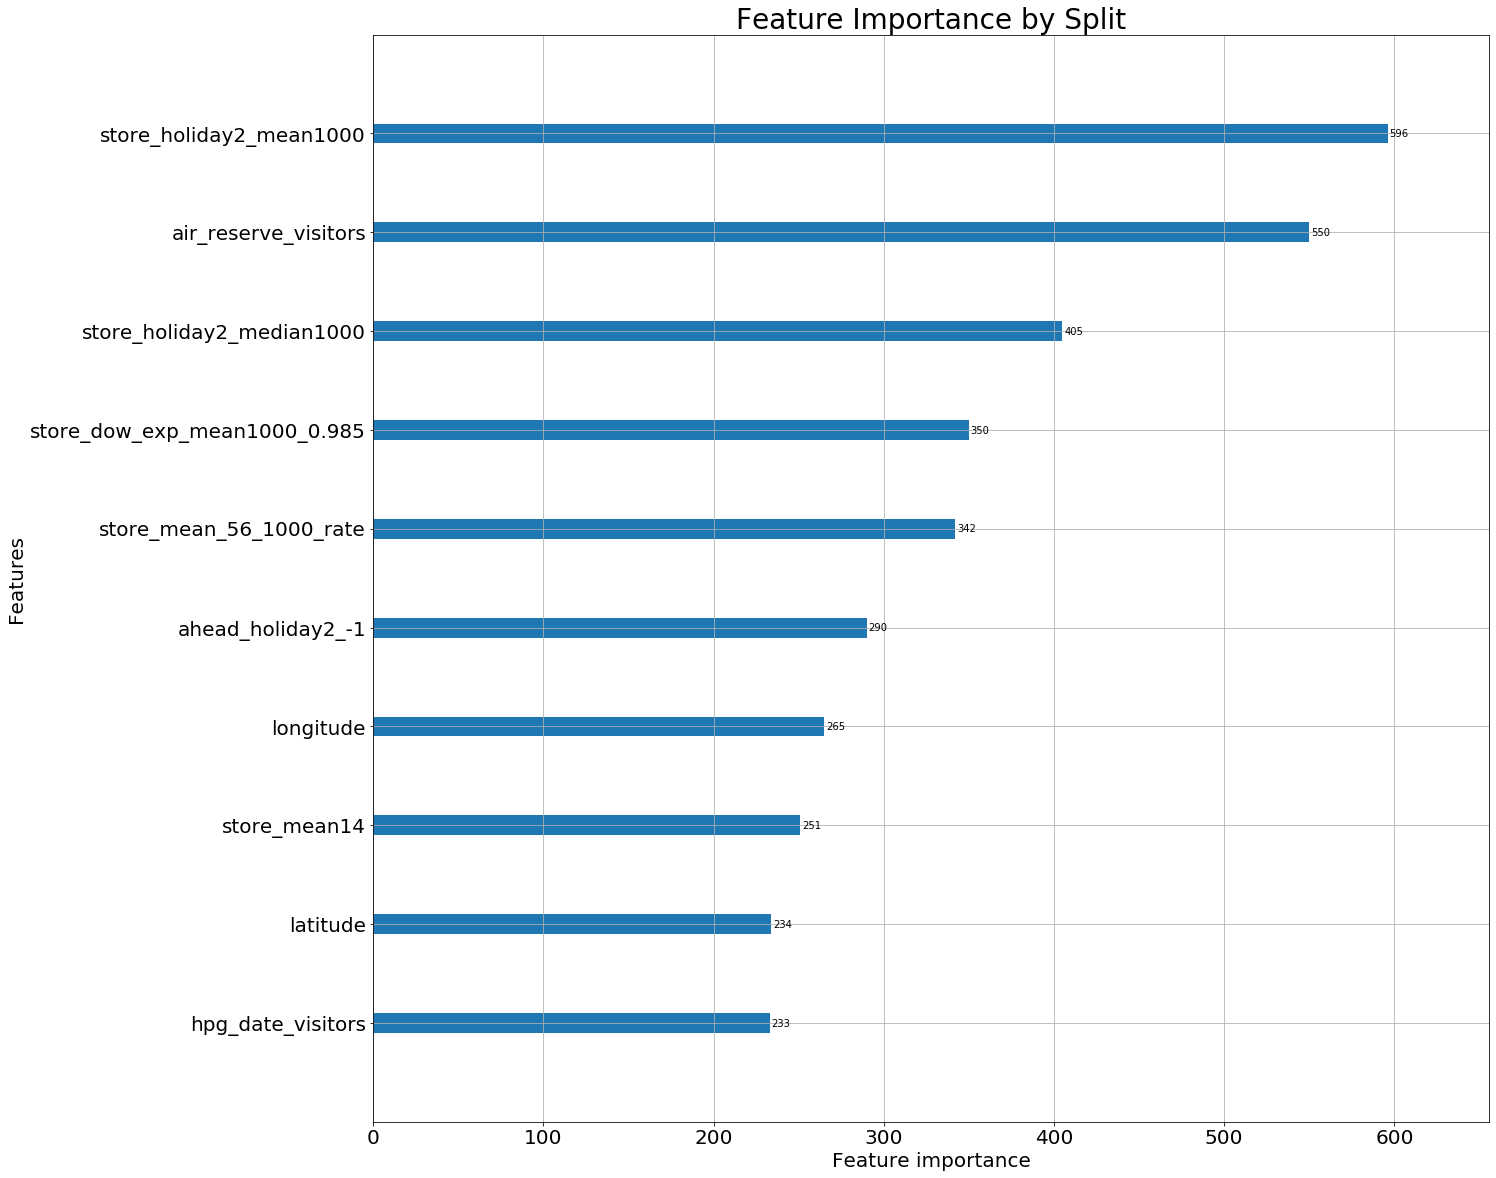

In [98]:
ax = lgb.plot_importance(gbm,title='Feature Importance by Split',\
                               xlabel='Feature importance', ylabel='Features',\
                            importance_type='split', max_num_features=10,
                   figsize=(20,20))
ax.title.set_fontsize(28)
for item in ([ax.xaxis.label, ax.yaxis.label] +
              ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)

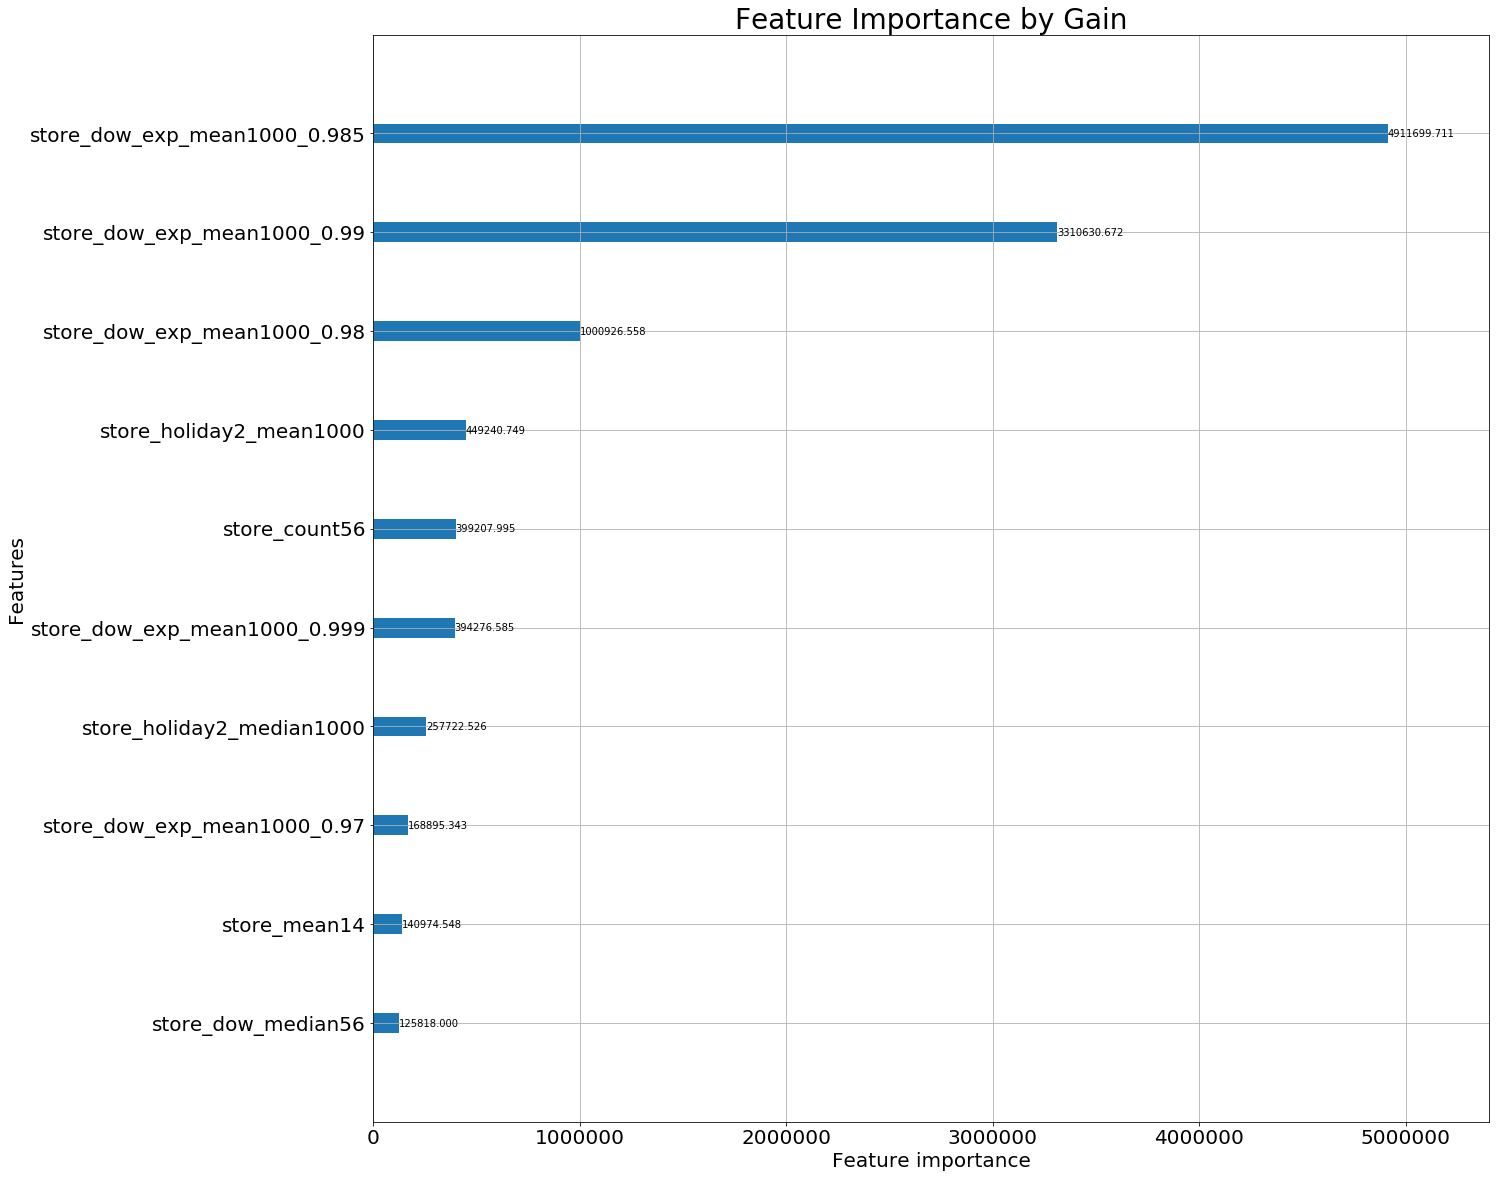

In [99]:
ax = lgb.plot_importance(gbm,title='Feature Importance by Gain',\
                               xlabel='Feature importance', ylabel='Features',\
                            importance_type='gain', max_num_features=10,
                   figsize=(20,20))
ax.title.set_fontsize(28)
for item in ([ax.xaxis.label, ax.yaxis.label] +
              ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)

In [96]:
#%time 
#shap_values = shap.TreeExplainer(lgbm_model1, approximate=True,tree_limit=80).shap_values(x_train_s)
#shap.summary_plot(shap_values, x_train_s)

## Prediction Output - Overall

In [153]:
predtraindf=predtraindf.rename(columns={'id':'store_id'})
output_comparison=air_visit.merge(predtraindf, how = 'left', on = ['store_id','visit_date'])
output_comparison.dropna(inplace=True)

In [154]:
output_comparison = output_comparison.groupby(['visit_date'],as_index=False).agg({"visitors_x":"sum",
                                                             "visitors_y":"sum"})
output_comparison=output_comparison.rename(columns={'visitors_x':'actual',
                                 'visitors_y':'forecast_lgbm'})
output_comparison=output_comparison[output_comparison.visit_date >= '2016-07-01']
output_comparison['visit_date']=[pd.to_datetime(i) for i in output_comparison.visit_date]
output_comparison.head()

,visit_date,actual,forecast_lgbm
145,2016-07-01,92930,72565.816049
146,2016-07-02,97560,79538.419659
147,2016-07-03,79482,64085.426824
148,2016-07-04,62658,52946.378876
149,2016-07-05,73704,62326.838689


In [167]:
pal = sns.color_palette("husl",9)
pal_set = pal.as_hex()

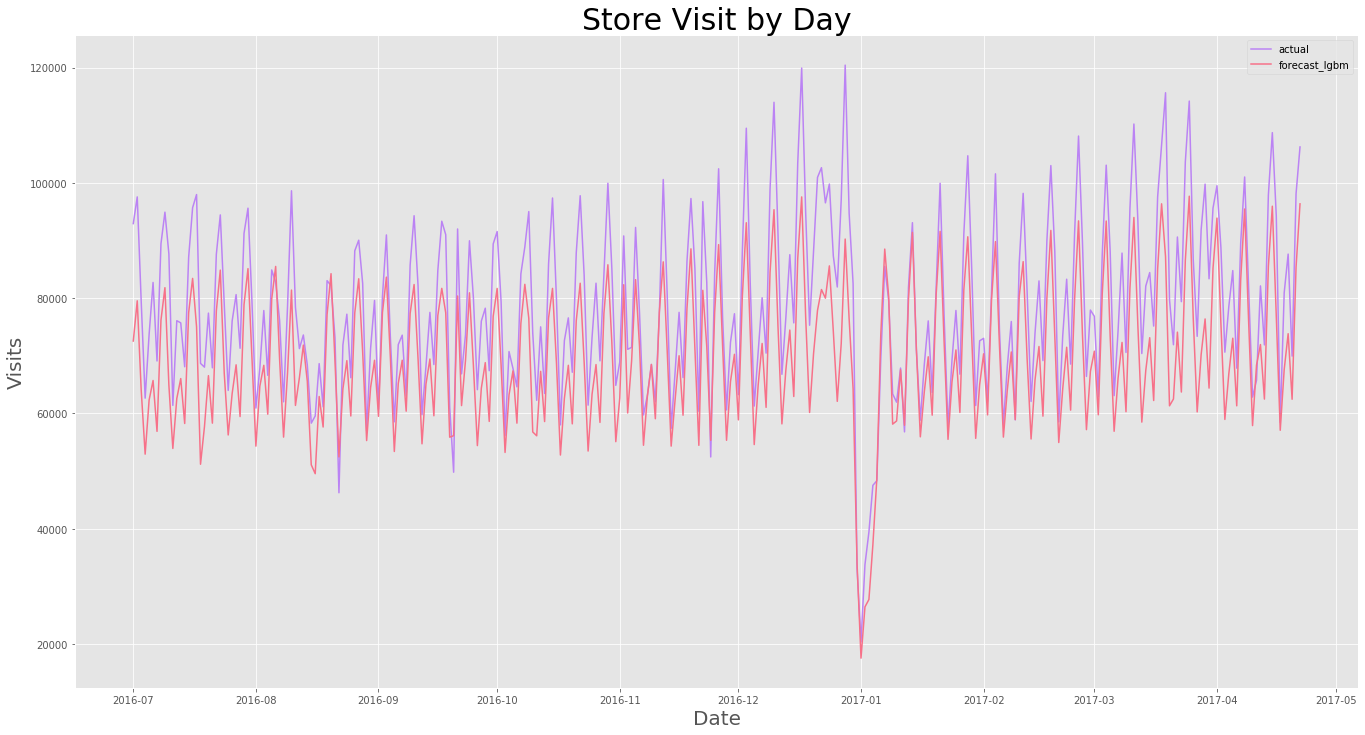

In [158]:
plt.style.use('ggplot')
plt.figure(figsize=(23, 12))
plt.plot(output_comparison['visit_date'], output_comparison['actual'], '#bb83f4', label = 'actual')
plt.plot(output_comparison['visit_date'], output_comparison['forecast_lgbm'], '#f77189', label = 'forecast_lgbm')
plt.xlabel('Date',fontsize=20)
plt.ylabel('Visits',fontsize=20)
plt.title('Store Visit by Day', size=30)
plt.legend()
plt.show()

In [199]:
mse = sklearn.metrics.mean_squared_error(output_comparison.actual,\
                                         output_comparison.forecast_lgbm)
rmse = np.sqrt(mse)
#np.sqrt(np.mean((output_comparison.actual-output_comparison.forecast_lgbm)**2))
print(rmse)

10933.446182626058


## Prediction Output by Top 80% Genre and Top Area

In [245]:
top80df=pd.read_csv('top80storeID.csv')
act_fcst_df=air_visit.merge(predtraindf, how = 'left', on = ['store_id','visit_date'])\
        .rename(columns={'visitors_x':'actual',
                         'visitors_y':'forecast_lgbm'})
alloutputdf= act_fcst_df.merge(top80df, how = 'left', on = 'store_id')

In [250]:
output_df = alloutputdf.dropna()

In [251]:
genrerollup = output_df.groupby(['visit_date','air_genre_name'], as_index = False).agg({"actual":"sum",
                                                                                        "forecast_lgbm":"sum"})

In [252]:
genrerollup['visit_date']=[pd.to_datetime(i, format="%Y/%m/%d") for i in genrerollup.visit_date]

66644.94600712428


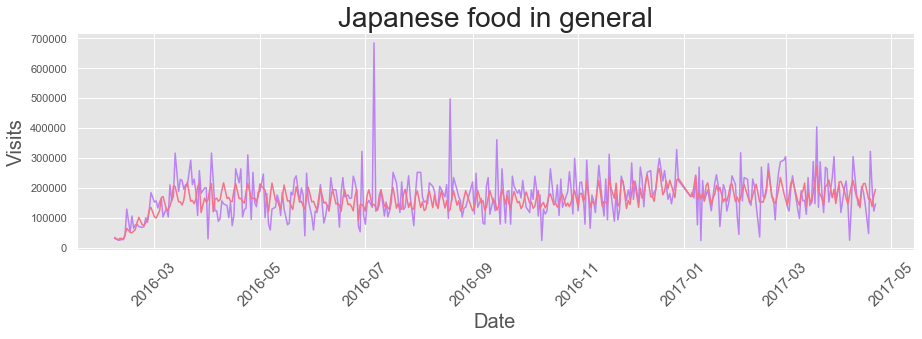

In [283]:
x=genrerollup[genrerollup.air_genre_name==genrerollup["air_genre_name"].unique()[0]]\
                .sort_values(by=['visit_date'])
mse = sklearn.metrics.mean_squared_error(x.actual, x.forecast_lgbm)
rmse = np.sqrt(mse)
print(rmse)


plt.figure(figsize=(15,4))
plt.plot(x['visit_date'], x['actual'], '#bb83f4', label = 'actual')
plt.plot(x['visit_date'], x['forecast_lgbm'], '#f77189', label = 'forecast_lgbm')
plt.xlabel('Date',fontsize=20)
plt.ylabel('Visits',fontsize=20)
plt.xticks(rotation=45, fontsize=15)
plt.title("Japanese food in general",fontsize=28)
plt.show()

141872.15513228954


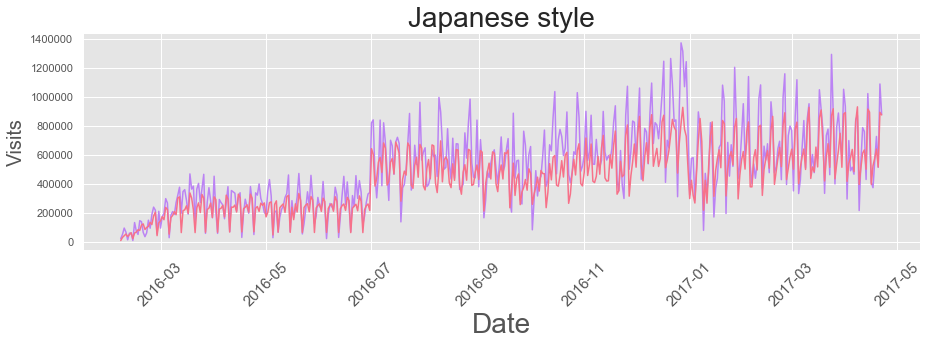

In [285]:
x=genrerollup[genrerollup.air_genre_name==genrerollup["air_genre_name"].unique()[1]]\
                .sort_values(by=['visit_date'])
mse = sklearn.metrics.mean_squared_error(x.actual, x.forecast_lgbm)
rmse = np.sqrt(mse)
print(rmse)

plt.figure(figsize=(15,4))
plt.plot(x['visit_date'], x['actual'], '#bb83f4', label = 'actual')
plt.plot(x['visit_date'], x['forecast_lgbm'], '#f77189', label = 'forecast_lgbm')
plt.xlabel('Date',fontsize=28)
plt.ylabel('Visits',fontsize=20)
plt.xticks(rotation=45, fontsize=15)
plt.title("Japanese style",fontsize=28)
plt.show()

140690.16795533022


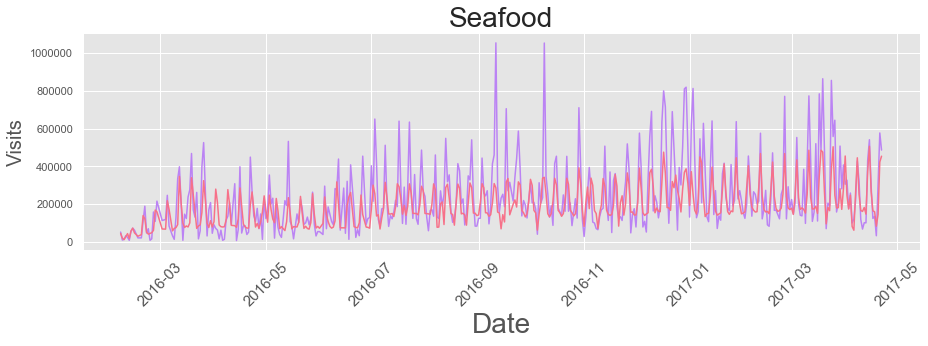

In [286]:
x=genrerollup[genrerollup.air_genre_name==genrerollup["air_genre_name"].unique()[2]]\
                .sort_values(by=['visit_date'])
mse = sklearn.metrics.mean_squared_error(x.actual, x.forecast_lgbm)
rmse = np.sqrt(mse)
print(rmse)

plt.figure(figsize=(15,4))
plt.plot(x['visit_date'], x['actual'], '#bb83f4', label = 'actual')
plt.plot(x['visit_date'], x['forecast_lgbm'], '#f77189', label = 'forecast_lgbm')
plt.xlabel('Date',fontsize=28)
plt.ylabel('Visits',fontsize=20)
plt.xticks(rotation=45, fontsize=15)
plt.title("Seafood",fontsize=28)
plt.show()

54751.88693567159


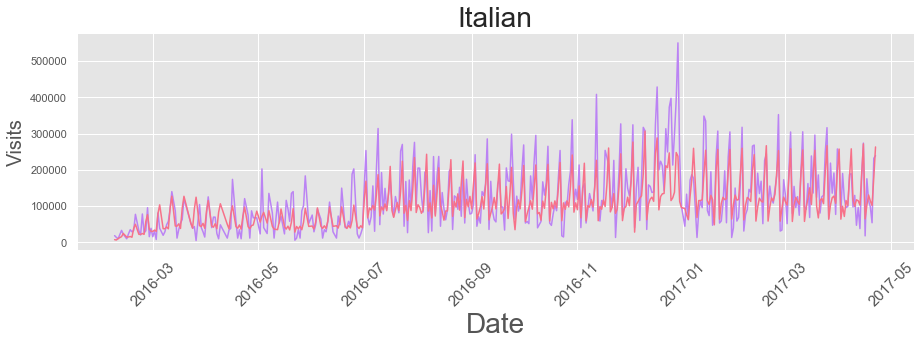

In [287]:
x=genrerollup[genrerollup.air_genre_name==genrerollup["air_genre_name"].unique()[3]]\
                .sort_values(by=['visit_date'])
mse = sklearn.metrics.mean_squared_error(x.actual, x.forecast_lgbm)
rmse = np.sqrt(mse)
print(rmse)

plt.figure(figsize=(15,4))
plt.plot(x['visit_date'], x['actual'], '#bb83f4', label = 'actual')
plt.plot(x['visit_date'], x['forecast_lgbm'], '#f77189', label = 'forecast_lgbm')
plt.xlabel('Date',fontsize=28)
plt.ylabel('Visits',fontsize=20)
plt.xticks(rotation=45, fontsize=15)
plt.title("Italian",fontsize=28)
plt.show()

159396.3442542222


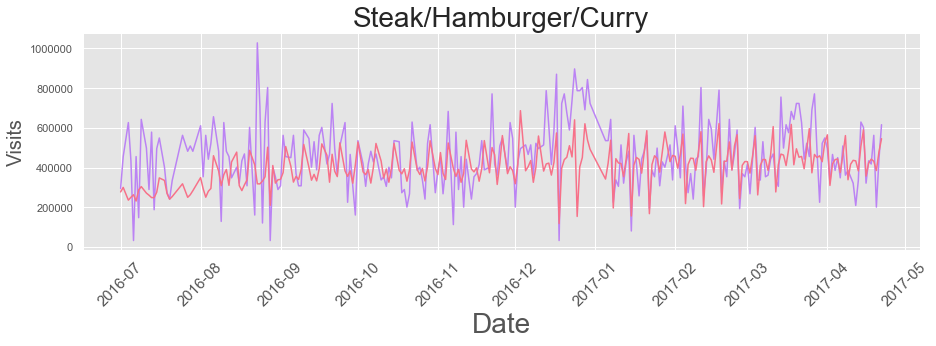

In [291]:
x=genrerollup[genrerollup.air_genre_name==genrerollup["air_genre_name"].unique()[4]]\
                .sort_values(by=['visit_date'])
mse = sklearn.metrics.mean_squared_error(x.actual, x.forecast_lgbm)
rmse = np.sqrt(mse)
print(rmse)


plt.figure(figsize=(15,4))
plt.plot(x['visit_date'], x['actual'], '#bb83f4', label = 'actual')
plt.plot(x['visit_date'], x['forecast_lgbm'], '#f77189', label = 'forecast_lgbm')
plt.xlabel('Date',fontsize=28)
plt.ylabel('Visits',fontsize=20)
plt.xticks(rotation=45, fontsize=15)
plt.title("Steak/Hamburger/Curry",fontsize=28)
plt.show()

30752.730021653475


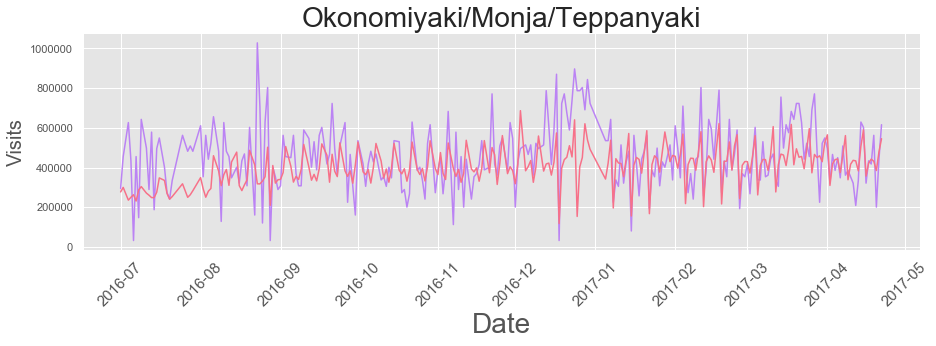

In [293]:
x=genrerollup[genrerollup.air_genre_name==genrerollup["air_genre_name"].unique()[5]]\
                .sort_values(by=['visit_date'])
mse = sklearn.metrics.mean_squared_error(x.actual, x.forecast_lgbm)
rmse = np.sqrt(mse)
print(rmse)

x=genrerollup[genrerollup.air_genre_name==genrerollup["air_genre_name"].unique()[4]]\
                .sort_values(by=['visit_date'])
plt.figure(figsize=(15,4))
plt.plot(x['visit_date'], x['actual'], '#bb83f4', label = 'actual')
plt.plot(x['visit_date'], x['forecast_lgbm'], '#f77189', label = 'forecast_lgbm')
plt.xlabel('Date',fontsize=28)
plt.ylabel('Visits',fontsize=20)
plt.xticks(rotation=45, fontsize=15)
plt.title("Okonomiyaki/Monja/Teppanyaki",fontsize=28)
plt.show()